<a href="https://colab.research.google.com/github/lucasestrela/Dissertacao/blob/main/Rodando_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importando pacotes

In [24]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2) Importando os dados

Irei utilizar os custos do ciclo calculados e as informações dos países.

In [25]:
#############################################################################
######################## --- Lendo Base de Dados --- ########################
#############################################################################
custo = pd.read_csv('https://raw.githubusercontent.com/lucasestrela/Dissertacao/main/Dados/custos_data%20(4).csv',
                    header = 0,
                    index_col = 0
                    )


dados_paises = pd.read_csv('https://raw.githubusercontent.com/lucasestrela/Dissertacao/main/Dados/countries_data.csv',
                    header = 0,
                    index_col = 0
                    )

Faço o merge dos dataframes

In [26]:
# Fazendo o merge dos dois datasets
dataframe = pd.merge(custo, dados_paises, on='countrycode', left_index=True, right_index=True, how='left')
dataframe[['log_gdp_percapta', 'log_emp_pop', 'log_labsh']] = np.log(dataframe[['gdp_percapta', 'emp_pop', 'labsh']])

# Apagando as outras variáveis
del custo, dados_paises

# Qual medida de custo irei utilizar
var_custo = 'custo_5_1'

In [27]:
dataframe.head()

,custo_5_1,custo_4_1,custo_4_3,custo_obts,countrycode,lvau_garriga,lvaw_garriga,stab_n,stab_s,gdp_percapta,emp_pop,avh,hc,rwtfpna,labsh,Freedom of elections,Electoral processes,Representative Institutions,Oversight institutions,Influence of organizations,Involvement of the military in politics,Political or Social expression via ITC,Population participation (national level),Population participation (local level),Freedom of association,Freedom of assembly,Equal treatment,Respect for the rights of minorities,Freedom of the Press,Genuine media pluralism,Freedom of access on the Internet,Freedom of access: cable/satellite,Freedom of access: foreign newspapers,Amendment of the rules governing the assumption of political office,Assumption of political office in accordance with the rules,Opposition to the most recent change of Head of State: political forces,Opposition to the most recent change of Head of State: population,Legitimacy of the political authorities: economic benefit,Legitimacy of the political authorities: social benefit,Legitimacy of the political authorities: national pride,...,Ability to hire foreign executives in firms,Quality of public services: primary and secondary education (urban areas),Quality of public services: primary and secondary education (rural areas),Quality of public services: higher education/university,Quality of public services: basic healthcare,Quality of public services: public transport,Disparity in labour income,Discrimination on the labour market: community-based,Discrimination on the labour market: gender,Child labour in urban areas,Child labour in rural areas,Role of networks in recruitment and promotion of senior officials,Role of networks in recruitment and promotion in the administration,Role of networks in recruitment and promotion in the private sector,Irregularities in obtaining university degrees,Upward social mobility linked to merit,Unemployment rate for young university graduates,Reluctance to hire higher university graduates,Share of higher education graduates: informal sector,Redistribution mechanisms: poorer section of the population,Redistribution mechanisms: disadvantaged areas,Recognition of occupational health,Recognition of occupational safety,Proportion of unemployed young people in rural areas,Proportion of unemployed young people in urban areas,inflation,social_contrib,legal_rights,gdp_grow,savings_gdp,educ_govexp_gdp,inc_10,pobreza_pop,unemployment,subnutri_pop,sub14_pop,idosos_pop,log_gdp_percapta,log_emp_pop,log_labsh
0,2.845531,1.189917e+01,1.439593e+01,6.607071,ABW,0.745530,0.807560,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.0,2.0,4.0,0.0,4.0,2.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0,4.0,3,4,4.0,0.0,3.0,3.0,1.0,1.0,1.0,...,3.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0,6.124620,0.409188,9.285714,6.664775,NaN,2.529187,NaN,NaN,11.480667,31.366667,46.261307,2.452326,NaN,NaN,NaN
1,37.783941,inf,inf,55.352812,AGO,NaN,NaN,0.0,0.0,0.031580,0.562555,NaN,1.223680,1.11829,0.288399,2.0,1.0,2.0,2.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3,2,4.0,1.0,1.0,2.0,1.0,1.0,4.0,...,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1,3.0,4.0,2.0,1.0,1.0,2.0,2.0,1.0,0,381.429413,2.029665,1.000000,3.678648,31.500897,3.483620,1.466667,40.233333,5.151667,39.705556,46.456335,2.586396,-3.455220,-0.575267,-1.243412
2,27.234440,4.750839e+46,1.805884e+68,23.866193,AIA,0.670737,0.651866,0.0,0.0,0.256826,0.351060,NaN,2.450292,NaN,NaN,3.0,1.0,3.0,3.0,3.0,0.0,2.0,2.0,2.0,4.0,4.0,4.0,2.0,3.0,1.0,4.0,4,4,3.0,4.0,4.0,0.0,1.0,2.0,3.0,...,3.0,3.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,2,3.0,4.0,3.0,1.0,1.0,2.0,2.0,2.0,2,16.303826,18.311541,7.000000,2.950957,18.678110,3.418164,3.377778,1.044444,15.440333,5.805556,32.159228,7.181680,-1.359355,-1.046797,NaN
3,5.132197,2.166405e+01,2.830731e+01,17.052578,ALB,0.537630,0.515500,0.0,0.0,0.161813,0.547194,NaN,2.193944,NaN,NaN,99.0,99.0,4.0,99.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,1.0,2.0,3,3,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


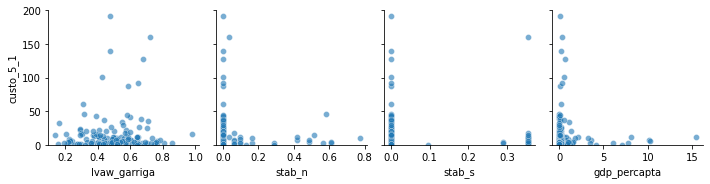

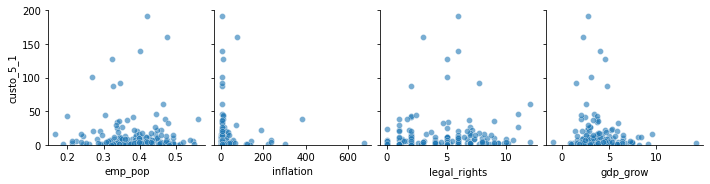

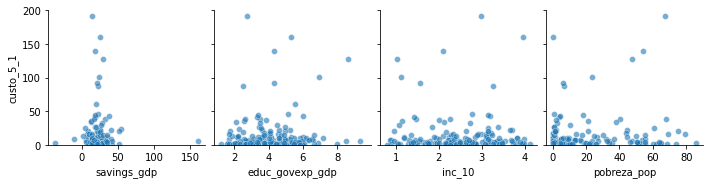

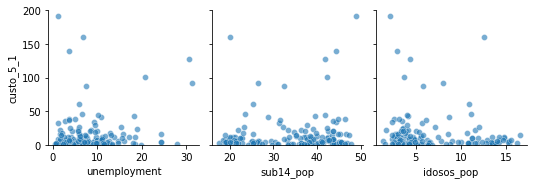

In [28]:
# Scatter plot do custo com diversas variáveis
var_list = np.array([
                     ['lvaw_garriga', 'stab_n', 'stab_s', 'gdp_percapta'],
                     ['emp_pop', 'inflation', 'legal_rights', 'gdp_grow'],
                     ['savings_gdp', 'educ_govexp_gdp', 'inc_10', 'pobreza_pop'],
                     ['unemployment', 'sub14_pop', 'idosos_pop']
                    ])


for vars in var_list:

    sns.pairplot(
                data = dataframe,
                y_vars=[var_custo],
                x_vars=vars,
                plot_kws = {'alpha': 0.6}
                )

    plt.ylim(0,200)
plt.show()

# 3) Rodando o Modelo

Para o python, é válido separar as variáveis entre X (covariadas) e y (variável independente) em dois dataframes separados.

In [29]:
##############################################################################
######################## --- Separando covariadas --- ########################
##############################################################################

# Eliminando os custos acima de 200
df_filtered = dataframe[dataframe[var_custo] < 200]

# Selecionando quais covariadas utilizarei
X = df_filtered[['lvaw_garriga', 'stab_n', 'stab_s', 'gdp_percapta', 'emp_pop',
                 'inflation', 'legal_rights', 'gdp_grow', 'savings_gdp',
                 'educ_govexp_gdp', 'inc_10', 'pobreza_pop', 'unemployment', 'sub14_pop',
                 'idosos_pop']]

# Adicionando intercepto
X = sm.add_constant(X)

# Selecionando variável independente
y = df_filtered[var_custo]


# Rodando o modelo
model = sm.OLS(y, X, missing='drop').fit(cov_type='HC0')

# Printando os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              custo_5_1   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.420
Date:                Wed, 19 May 2021   Prob (F-statistic):              0.150
Time:                        21:46:27   Log-Likelihood:                -604.98
No. Observations:                 128   AIC:                             1242.
Df Residuals:                     112   BIC:                             1288.
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.5580     65.339     

In [30]:
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle # Para selecionar as cores dos graficos

In [31]:
# Contando quantos missings cada coluna possui
total_na = df_filtered.isna().sum().sort_values()

# Selecionando as variáveis que possuem mais do que 30 missings
total_na = total_na[total_na > 30].index

# Removendo colunas que tem muitos NAN
df = df_filtered.drop(total_na, axis=1)
df = df.drop(['log_emp_pop', 'log_gdp_percapta', 'inflation'], axis=1)

# Removendo os NANs das colunas restantes
df = df.dropna()

# Filtrando as colunas que sao object
df = df.select_dtypes(exclude=['object'])

# Selecionando covariadas
X = df.iloc[:, 4:]
X = sm.add_constant(X) # Adicionando constante

# Selecionando variável independente
y = df[var_custo]

# Obtendo as colunas que sobraram neste df
feature_names  = X.columns

# Standardize data (easier to set the l1_ratio parameter)
# X = X.std(axis=1)



In [32]:
eps = 5e-2  # the smaller it is the longer is the path

# Rodando o LASSO
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, fit_intercept=False)

# Rodando o Positive LASSO
print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps=eps, positive=True, fit_intercept=False)

# Rodando o Elastic Net
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

# Rodando o Positive Elastic Net
print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


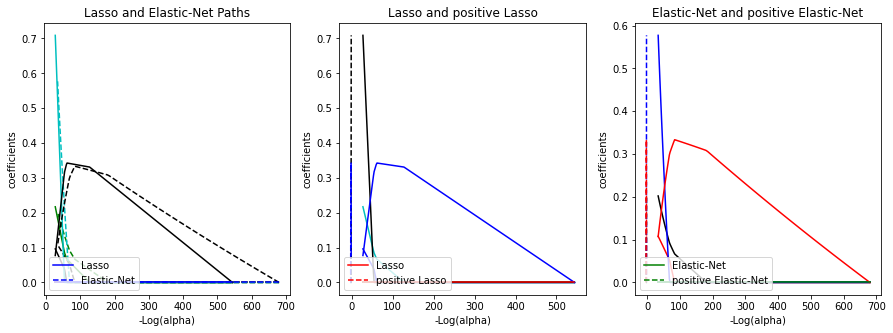

In [33]:
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = alphas_lasso
neg_log_alphas_enet = alphas_enet


f, axes = plt.subplots(1, 3,figsize=(15, 5) )

# Plotando o LASSO e Elastic Net com diferentes alphas
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = axes[0].plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = axes[0].plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

axes[0].set_xlabel('-Log(alpha)')
axes[0].set_ylabel('coefficients')
axes[0].set_title('Lasso and Elastic-Net Paths')
axes[0].legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')



# Plotando o LASSO e Positive LASSO com diferentes alphas

neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = axes[1].plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = axes[1].plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)


axes[1].set_xlabel('-Log(alpha)')
axes[1].set_ylabel('coefficients')
axes[1].set_title('Lasso and positive Lasso')
axes[1].legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')



# Plotando o Elastic Net e Positive Elastic Net com diferentes alphas

neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = axes[2].plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = axes[2].plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

axes[2].set_xlabel('-Log(alpha)')
axes[2].set_ylabel('coefficients')
axes[2].set_title('Elastic-Net and positive Elastic-Net')
axes[2].legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [34]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import scipy as sp
from sklearn.preprocessing import StandardScaler

In [35]:
# A pensar no que fazer com dados do IPD. Variam de 1 a 5 como um 'ranking'
categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR',
                       'MARR', 'UNION', 'SEX', 'SOUTH']

numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']


# Nesta etapa eu estaria automatizando o tratamento de variáveis categoricas (fazendo o one hot encoding)
# e variáveis numéricas (padronizando cada uma).
preprocessor = make_column_transformer(
                                       (OneHotEncoder(drop='if_binary'), categorical_columns),
                                       (StandardScaler(), numerical_columns),
                                       remainder='passthrough'
                                       )


# Dividindo a amostra entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [36]:
# Rodando o LASSO e escolhendo o alpha por CV
model_lasso = make_pipeline(
                            TransformedTargetRegressor(
                            regressor=LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=100000),
                            func=np.log10,
                            inverse_func=sp.special.exp10
                                                      )
                            )


# Rodando RIDGE e escolhendo o alpha por CV
model_ridge = make_pipeline(
                            TransformedTargetRegressor(
                            regressor = RidgeCV(alphas=np.logspace(-10, 10, 21)),
                            func = np.log10,
                            inverse_func = sp.special.exp10
                                                      )
                            
                            )



In [37]:
# Fitando o LASSO
model_lasso.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)

# Criando um dataframe com os coeficientes
coefs_lasso = pd.DataFrame(
                           model_lasso.named_steps['transformedtargetregressor'].regressor_.coef_,
                           columns=['Coefficients'], 
                           index = feature_names
                           )

# Criando um dataframe com os coeficientes
coefs_ridge = pd.DataFrame(
                           model_ridge.named_steps['transformedtargetregressor'].regressor_.coef_,
                           columns=['Coefficients'], 
                           index = feature_names
                           )

Não podemos comparar a magnitude de coeficientes diferentes, uma vez que as características têm escalas naturais diferentes e, portanto, intervalos de valores, por causa de suas unidades de medida diferentes. Isso é mais visível se plotarmos os coeficientes.

In [38]:
print(coefs_ridge)

                 Coefficients
const            0.000000e+00
lvau_garriga     9.158279e-11
lvaw_garriga     1.114332e-10
stab_n           3.304930e-11
stab_s           2.565500e-11
gdp_percapta     2.509319e-10
emp_pop          6.534611e-12
legal_rights     6.074954e-10
gdp_grow        -1.952566e-09
savings_gdp     -1.235079e-10
educ_govexp_gdp  8.543105e-10
inc_10          -3.119420e-10
pobreza_pop      1.589689e-08
unemployment     6.808151e-09
sub14_pop        2.966523e-09
idosos_pop       1.929825e-10


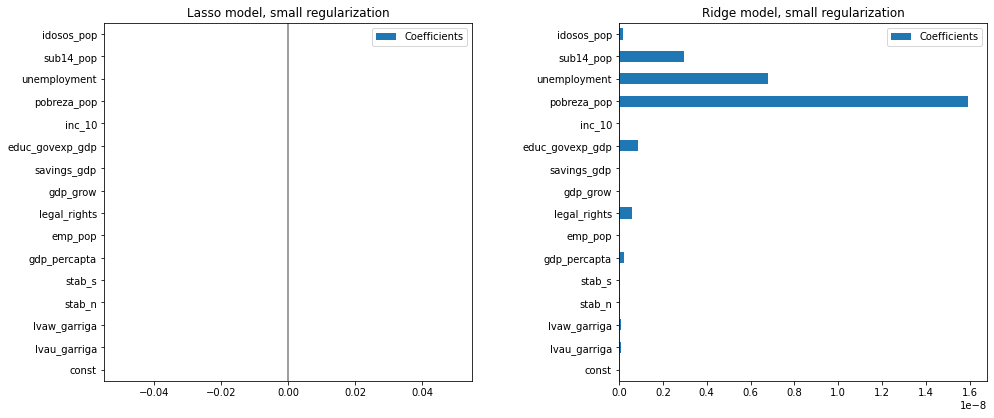

In [39]:
# Plotando os coeficientes
f, axes = plt.subplots(1, 2, figsize=(15, 7) )


coefs_lasso.plot(kind='barh', ax = axes[0])

axes[0].set_title('Lasso model, small regularization')
axes[0].axvline(x=0, color='.5')

# ------------------------------------------------------ #

# Plotando os coeficientes
coefs_ridge.plot(kind='barh', ax = axes[1])

axes[1].set_title('Ridge model, small regularization')
axes[1].axvline(x=0, color='.5')

f.tight_layout(pad = 5.0)

Olhar para o gráfico do coeficiente para medir a importância do recurso pode ser enganoso, pois alguns deles variam em pequena escala, enquanto outros, como AGE, variam muito mais, várias décadas.

Isso é visível se compararmos os desvios padrão de recursos diferentes.

In [40]:
# X_train_preprocessed_lasso = pd.DataFrame(
#                                           model_lasso.named_steps['columntransformer'].transform(X_train),
#                                           columns=feature_names
#                                           )


# X_train_preprocessed_ridge = pd.DataFrame(
#                                           model_ridge.named_steps['columntransformer'].transform(X_train),
#                                           columns = feature_names
#                                           )


# X_train_preprocessed_lasso.std(axis=0).plot(kind='barh', figsize=(9, 7))
# plt.title('Features std. dev.')
# plt.subplots_adjust(left=.3)

# X_train_preprocessed_ridge.std(axis=0).plot(kind='barh', figsize=(9, 7))
# plt.title('Features std. dev.')
# plt.subplots_adjust(left=.3)

Multiplicar os coeficientes pelo desvio padrão do recurso relacionado reduziria todos os coeficientes à mesma unidade de medida. Como veremos a seguir, isso é equivalente a normalizar variáveis numéricas para seu desvio padrão, como.

$$y = \sum coef_i \times X_i = \sum (coef_i \times std_i) \times (X_i/std_i)$$

Dessa forma, enfatizamos que quanto maior a variância de um recurso, maior o peso do coeficiente correspondente na saída, sendo todo o resto igual.

In [41]:
coefs_ridge = pd.DataFrame(
    model_ridge.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)

coefs_lasso = pd.DataFrame(
    model_lasso.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)

emp_pop = % da População Empregada

hc = Human capital index

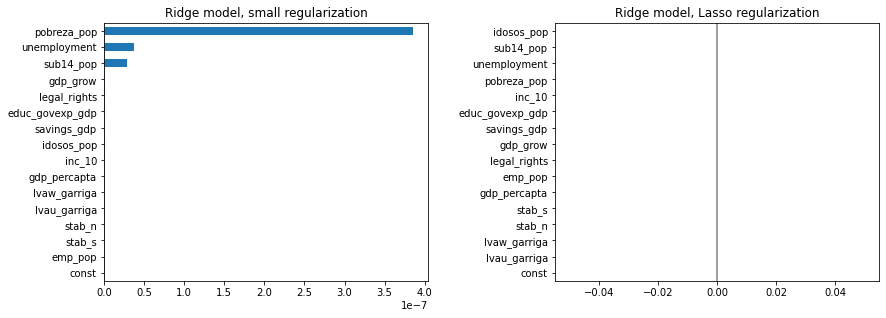

In [42]:
# Plotando os coeficientes
f, axes = plt.subplots(1, 2, figsize=(15, 7) )

# Plotando os coeficientes
coefs_ridge.iloc[coefs_ridge['Coefficient importance'].abs().argsort()].plot(kind='barh', ax = axes[0])

axes[0].set_title('Ridge model, small regularization')
axes[0].axvline(x=0, color='.5')
axes[0].get_legend().remove()

f.tight_layout(pad = 10.0)


# Plotando os coeficientes
coefs_lasso.iloc[coefs_lasso['Coefficient importance'].abs().argsort()].plot(kind='barh', ax = axes[1])

axes[1].set_title('Ridge model, Lasso regularization')
axes[1].axvline(x=0, color='.5')
axes[1].get_legend().remove()

In [43]:
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

Aqui eu divido a amostra em 5 e repito 5 vezes, este procedimento, obtendo 25 coeficientes para um dado alpha. Antes eu repetia o mesmo procedimento para testar qual melhor alpha.

In [44]:
cv_model_ridge = cross_validate(
                                model_ridge, 
                                X, y,
                                cv = RepeatedKFold(n_splits = 5, n_repeats = 5),
                                return_estimator = True, 
                                n_jobs = -1
                                )


coefs_ridge = pd.DataFrame(
                          [
                           est.named_steps['transformedtargetregressor'].regressor_.coef_ * X_train.std(axis=0)
                           for est in cv_model_ridge['estimator']
                          ], 
                           columns = feature_names
                          )


# ----------------------------------------------------------------- #


cv_model_lasso = cross_validate(
                                model_lasso, 
                                X, y,
                                cv = RepeatedKFold(n_splits = 5, n_repeats = 5),
                                return_estimator = True, 
                                n_jobs = -1
                                )


coefs_lasso = pd.DataFrame([est.named_steps['transformedtargetregressor'].regressor_.coef_ * X_train.std(axis=0)
                            for est in cv_model_lasso['estimator']],
                            columns = feature_names)



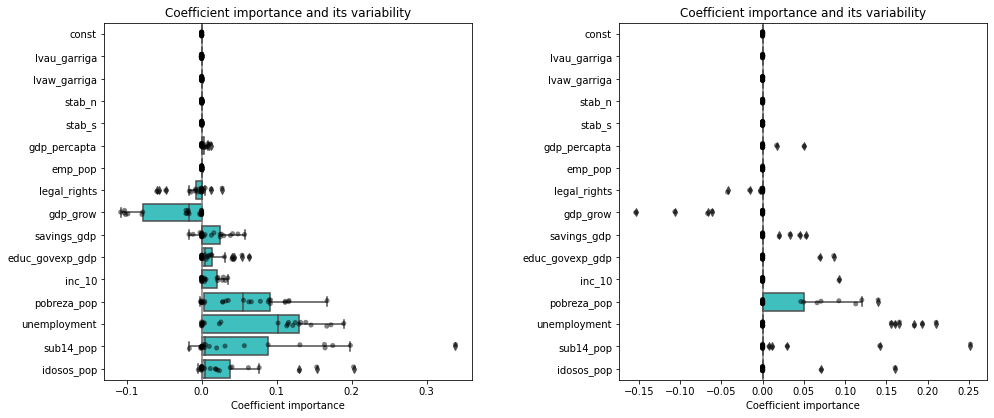

In [45]:
###########   Graficos   ###########


coef_list = [coefs_ridge, coefs_lasso]

f, axes = plt.subplots(1, 2, figsize=(15, 7) )

for i_coef, coefs in enumerate(coef_list):
    sns.stripplot(data = coefs, orient = 'h', color = 'k', alpha = 0.5, ax = axes[i_coef])
    sns.boxplot(  data = coefs, orient = 'h', color = 'cyan', saturation = 0.5, ax = axes[i_coef])

    axes[i_coef].axvline(x=0, color='.5')
    axes[i_coef].set_xlabel('Coefficient importance')
    axes[i_coef].set_title('Coefficient importance and its variability')

f.tight_layout(pad = 5.0)

Se os coeficientes variam significativamente ao alterar o conjunto de dados de entrada, sua robustez não é garantida e provavelmente devem ser interpretados com cautela.

In [46]:
# sns.pairplot(coefs_ridge)